In [1]:
# Step 0. Import libraries, custom modules and logging
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error,
                             r2_score)
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
# Step 1. Load data and get a first view -------------------------------
# 1.1 Read from source and get basic info
df_raw = pd.read_csv('skincancer.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   49 non-null     object 
 1   Lat     49 non-null     float64
 2   Mort    49 non-null     int64  
 3   Ocean   49 non-null     int64  
 4   Long    49 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.0+ KB


In [4]:
# 1.2 Get a sample
display(df_raw.sample(5, random_state=2024))

,State,Lat,Mort,Ocean,Long
24,Montana,47.0,109,0,110.5
17,Maine,45.2,117,1,69.0
39,SouthDakota,44.8,86,0,100.0
26,Nevada,39.0,191,0,117.0
12,Indiana,40.2,128,0,86.2


In [5]:
# Step 2. Prepara the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .rename(columns={'mort':'target'})
    .astype({'target': np.float16})
    .iloc[:,1:3]
)

In [6]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  49 non-null     float16
 1   lat     49 non-null     float64
dtypes: float16(1), float64(1)
memory usage: 622.0 bytes


In [10]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 28 to 33
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  39 non-null     float16
 1   lat     39 non-null     float64
dtypes: float16(1), float64(1)
memory usage: 702.0 bytes


In [8]:
display(df_train.describe().T)

,count,mean,std,min,25%,50%,75%,max
target,39.0,156.625000,32.062500,110.0,133.0,152.0,177.5,229.0
lat,39.0,39.187179,4.629663,28.0,35.5,39.0,43.0,47.5


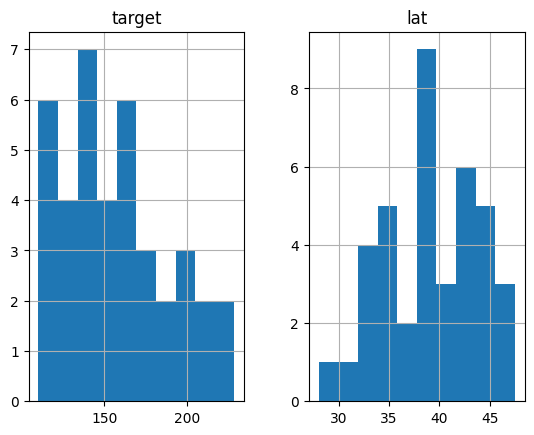

In [11]:
df_train.hist()
plt.show()

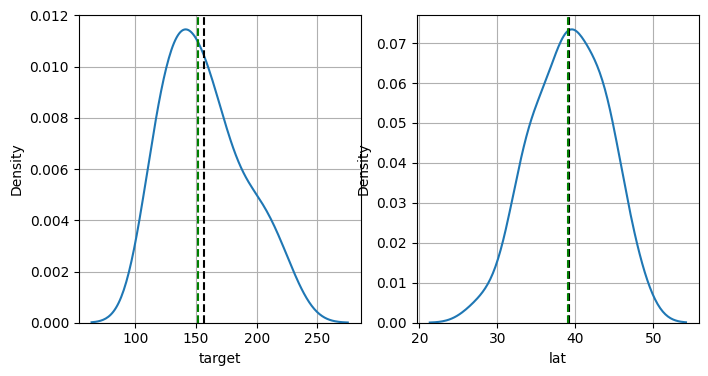

In [14]:
# 3.4 Perform univariate analysis on numerical variables using kde
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.kdeplot(data=df_train, x='target', ax=ax[0])
ax[0].axvline(x=df_train['target'].mean(), color='k', linestyle='--')
ax[0].axvline(x=df_train['target'].median(), color='g', linestyle='--')
sns.kdeplot(data=df_train, x='lat', ax=ax[1])
ax[1].axvline(x=df_train['lat'].mean(), color='k', linestyle='--')
ax[1].axvline(x=df_train['lat'].median(), color='g', linestyle='--')
ax[0].grid(True)
ax[1].grid(True)
plt.show()

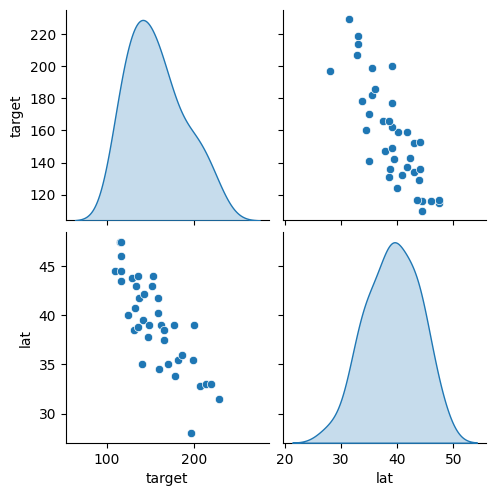

In [15]:
sns.pairplot(data= df_train, diag_kind="kde")
plt.show()

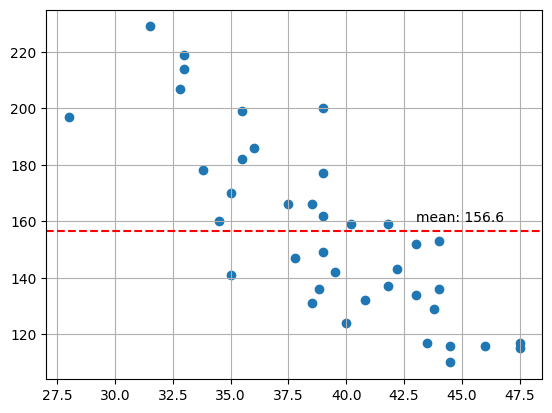

In [16]:
# 3.5 Perform bivariate analysis as a trend
plt.scatter(df_train['lat'],df_train['target'])
plt.axhline(df_train['target'].mean(),linestyle='--', c='r')
plt.annotate(text=f'mean: {df_train['target'].mean():.1f}', xy=(43,160))
plt.grid(True)
plt.show()

In [17]:
# Step 4. Experiment with models
# 4.1 Split features and reponse
X_train = df_train.drop('target', axis=1).reset_index(drop=True) # Independent variable
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.drop('target', axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True) # Dependent variable

In [18]:
# 4.2 Simple model
y_mean = np.repeat(df_train['target'].mean(), len(y_test))
print(f"MSE: {mean_squared_error(y_test, y_mean)}") # mean squuared error
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_mean))}") 
print(f"MAE: {mean_absolute_error(y_test, y_mean)}") # mean absolute error
print(f"R2: {r2_score(y_test, y_mean)}") 

MSE: 1526.0
RMSE: 39.0625
MAE: 36.84375
R2: -0.2783203125


In [19]:
reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)
y_pred = reg_lin.predict(X_test)

In [20]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}") # mean squuared error
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}") 
print(f"MAE: {mean_absolute_error(y_test, y_pred)}") # mean absolute error
print(f"R2: {r2_score(y_test, y_pred)}") 

MSE: 455.6222550767003
RMSE: 21.34530990819061
MAE: 18.426011636758354
R2: 0.6183556799263719


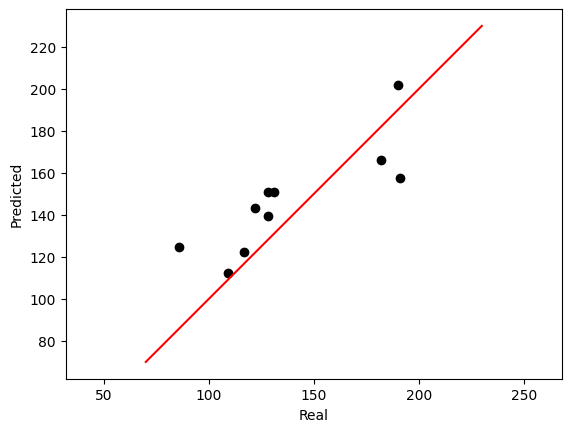

In [21]:
plt.scatter(x= y_test, y= y_pred, c='k')
plt.plot([70,230], [70,230], c='r')
plt.axis('equal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.show()

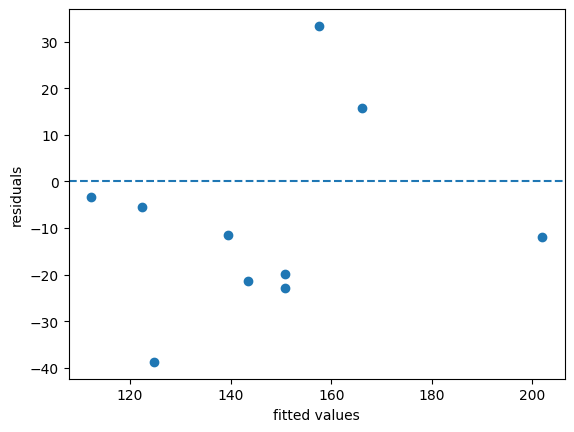

In [22]:
resid = y_test - y_pred
plt.scatter(x= y_pred, y= resid)
plt.axhline(0, linestyle= "--")
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.show()

In [26]:
print(f"mort = {reg_lin.intercept_:.1f} {reg_lin.coef_[0]:1f}*lat")

mort = 378.9 -5.671944*lat
